In [93]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import re
from pprint import pprint
from matplotlib.path import Path
from matplotlib.patches import BoxStyle

legend_location = 'upper right'


thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_contrast_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']

debug = 1
g = 0




def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
old_map_buffer_ratio = -1
print('ok')



ok


In [ ]:
# Get data for traditional and block-based districts

## Get congressional district boundaries

In [4]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 3.7 seconds.


### Get block group shapefiles (nationwide)

In [5]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 198.6 seconds!


## Look up state and county names from numbers

In [6]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 20.5 seconds!


## Get block group populations from ACS 2018 and join shapefiles

In [7]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 6 seconds!


## Get what has been matched so far

In [8]:
s = time.time()
print('reading districts that have been matched so far...')
#assembler_df = pandas.read_csv(output_dir+'raw_district_files/dallas.csv', encoding='utf-8', index_col='GEOID')
assembler_df = pandas.read_csv(output_dir+'raw_district_files/ak_to_tx.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))

assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


reading districts that have been matched so far...
Kept 217,739 block groups in 3.4 seconds!


STUSAB
TX    36.0
FL    27.0
NY    27.0
PA    18.0
IL    18.0
OH    16.0
GA    14.0
MI    14.0
NC    13.0
NJ    12.0
VA    11.0
WA    10.0
MA     9.0
TN     9.0
IN     9.0
AZ     9.0
MD     8.0
WI     8.0
MN     8.0
MO     8.0
SC     7.0
AL     7.0
CO     7.0
LA     6.0
KY     6.0
CT     5.0
OK     5.0
OR     5.0
MS     4.0
IA     4.0
KS     4.0
AR     4.0
UT     4.0
NV     4.0
NE     3.0
WV     3.0
NM     3.0
ME     2.0
ID     2.0
NH     2.0
HI     2.0
RI     2.0
WY     1.0
MT     1.0
DE     1.0
ND     1.0
SD     1.0
VT     1.0
AK     1.0
Name: block_based_district, dtype: float64

# Closeup of the weird thin part of Texas-33

## Get roads etc. in Texas

### From save

In [9]:
s = time.time()
water_gdf = geopandas.read_file(shapefiledir+'texas/water_texas.shp')
place_gdf = geopandas.read_file(shapefiledir+'texas/place_texas.shp')
roads_gdf = geopandas.read_file(shapefiledir+'texas/roads_texas.shp')
e = time.time()
g = g + (e-s)
print('Read Texas water/place/road shapefiles in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


Read Texas water/place/road shapefiles in 5 minutes 18 seconds!


In [3]:
### From scratch

In [ ]:
# s = time.time()

# this_state = 'TX'
# this_state_number = 48
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in  {1:,.0f} minutes {2:,.0f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# s = time.time()
# water_gdf.to_file(shapefiledir+'texas/water_texas.shp')
# place_gdf.to_file(shapefiledir+'texas/place_texas.shp')
# roads_gdf.to_file(shapefiledir+'texas/roads_texas.shp')
# e = time.time()

# print('Wrote outfiles in {0:,.0f} seconds!'.format(e-s))
print('ok')

## Define Dallas and Houston areas

Making Dallas box...
Making Houston box...
Any overlap? Found 0 block groups that overlap...


Found 5,020 block groups in the Dallas area; 3,818 in the Houston area; 6,973 in neither!
plotting...


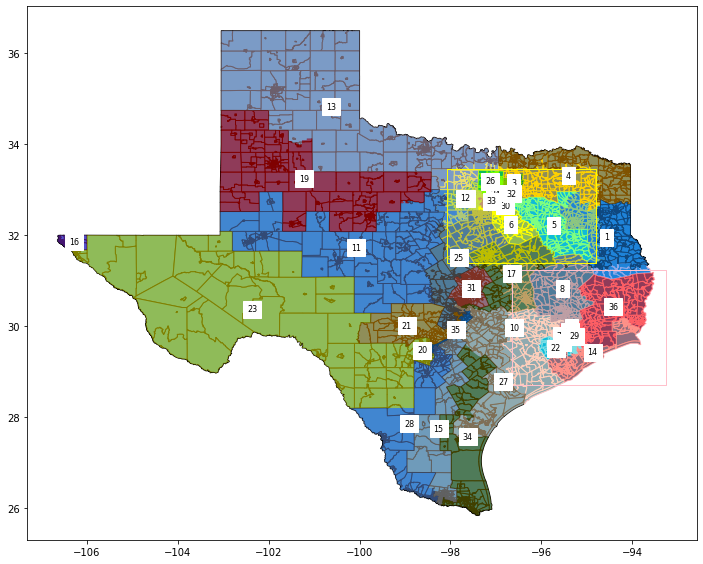

Defined Dallas and Houston areas in 5 minutes 50 seconds!
Done in  5 minutes 5.0 seconds!


In [10]:
s = time.time()
this_state = 'TX'
nDistricts = 36
color_reset_point = 17

#### DALLAS
dallas_west_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Palo Pinto County')].geometry.tolist()).bounds[2] - 0.025 # East border of Palo Pinto County
dallas_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Denton County')].geometry.tolist()).bounds[3] + 0.025   # North border of Denton County
dallas_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Morris County')].geometry.tolist()).bounds[0] + 0.025   # West border of Morris County
dallas_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Cherokee County')].geometry.tolist()).bounds[1] - 0.025   # South border of Cherokee County
xlim = [dallas_west_limit, dallas_east_limit]
ylim = [dallas_south_limit, dallas_north_limit]

print('Making Dallas box...')
dallas_geo = makebox(xlim, ylim)
if ('in_dallas' not in assembler_gdf.columns):
    assembler_gdf = assembler_gdf.assign(in_dallas = False)
assembler_gdf.loc[:, 'in_dallas'] = False
assembler_gdf.loc[
    (assembler_gdf['STUSAB'] == this_state) 
    & (assembler_gdf.geometry.apply(lambda x: x.intersects(dallas_geo))
      ), 'in_dallas'] = True


# #### HOUSTON
houston_west_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Brazos County')].geometry.tolist()).bounds[0] - 0.05 # West: western point of Brazos County
houston_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX')].geometry.tolist()).bounds[2] + 0.25 # East: eastern point of Texas
houston_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Brazoria County')].geometry.tolist()).bounds[1] - 0.05 # South: south point of Brazoria County
houston_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Newton County')].geometry.tolist()).bounds[3] + 0.05 # North: north point of Newton County

xlim = [houston_west_limit, houston_east_limit]
ylim = [houston_south_limit, houston_north_limit]

print('Making Houston box...')
houston_geo = makebox(xlim, ylim)

if ('in_houston' not in assembler_gdf.columns):
    assembler_gdf = assembler_gdf.assign(in_houston = False)
assembler_gdf.loc[:, 'in_houston'] = False
assembler_gdf.loc[
    (assembler_gdf['STUSAB'] == this_state) 
    & (assembler_gdf['in_dallas'] == False) 
    & (assembler_gdf.geometry.apply(lambda x: x.intersects(houston_geo))), 'in_houston'] = True

if ('in_neither' not in assembler_gdf.columns):
    assembler_gdf = assembler_gdf.assign(in_neither = False)
assembler_gdf.loc[:, 'in_neither'] = False
assembler_gdf.loc[
    (assembler_gdf['STUSAB'] == this_state) 
    & (assembler_gdf['in_dallas'] == False) 
    & (assembler_gdf['in_houston'] == False), 'in_neither'] = True



print('Any overlap? Found {0:,.0f} block groups that overlap...'.format(len(assembler_gdf[(assembler_gdf['in_dallas'] == True) & (assembler_gdf['in_houston'] == True)])))
print('\n')
print('Found {0:,.0f} block groups in the Dallas area; {1:,.0f} in the Houston area; {2:,.0f} in neither!'.format(len(assembler_gdf[assembler_gdf['in_dallas'] == True]), len(assembler_gdf[assembler_gdf['in_houston'] == True]), len(assembler_gdf[assembler_gdf['in_neither'] == True])))

print('plotting...')
dallas_geo_gdf = geopandas.GeoDataFrame(data=[[dallas_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')
houston_geo_gdf = geopandas.GeoDataFrame(data=[[houston_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

fig, ax = plt.subplots(1,1, figsize=(12,12))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax)

assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['in_dallas'] == True)].plot(ax=ax, edgecolor='yellow')
assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['in_houston'] == True)].plot(ax=ax, edgecolor='pink')
assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['in_neither'] == True)].plot(ax=ax, edgecolor='black')

for i in range(1, nDistricts+1):
    cd_gdf[
        (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
    ].plot(ax=ax, color=district_color_cycle[np.mod(i-1, color_reset_point)-1], alpha=0.5)
    annotator = i
    centerpoint = cd_gdf[
        (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
    ].geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).values[0]
    plt.annotate(annotator, centerpoint, 
                 ha='center', va='center', fontsize=8,
                 color='black', backgroundcolor='white')

dallas_geo_gdf.plot(ax=ax, color='none', edgecolor='yellow')
houston_geo_gdf.plot(ax=ax, color='none', edgecolor='pink')

# # plt.xlim(dallas_west_limit - 0.1, dallas_east_limit + 0.1)
# # plt.ylim(dallas_south_limit - 0.1, dallas_north_limit + 0.1)
# # plt.xlim(houston_west_limit - 0.1, houston_east_limit + 0.1)
# # plt.ylim(houston_south_limit - 0.1, houston_north_limit + 0.1)
plt.show()
e = time.time()
g = g + (e-s)
# #print('Plotted Dallas and Houston areas in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

print('Defined Dallas and Houston areas in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
print('Done in  {0:,.0f} minutes {0:.1f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



### Divide roads into Dallas/Houston/other

In [11]:
s = time.time()
print('splitting water areas...')
water_dallas_gdf = water_gdf[water_gdf.geometry.within(dallas_geo)]
water_houston_gdf = water_gdf[water_gdf.geometry.within(houston_geo)] 
water_other_gdf = water_gdf[~(water_gdf.geometry.within(dallas_geo)) & ~(water_gdf.geometry.within(houston_geo))] 

print('splitting places...')
place_dallas_gdf = place_gdf[place_gdf.geometry.within(dallas_geo)] # 382 rows
place_houston_gdf = place_gdf[place_gdf.geometry.within(houston_geo)] # 259 rows
place_other_gdf = place_gdf[~(place_gdf.geometry.within(dallas_geo)) & ~(place_gdf.geometry.within(houston_geo))] # 1105 rows

print('splitting roads...')
roads_dallas_gdf = roads_gdf[roads_gdf.geometry.within(dallas_geo)]
roads_houston_gdf = roads_gdf[roads_gdf.geometry.within(houston_geo)]
roads_other_gdf = roads_gdf[~(roads_gdf.geometry.within(dallas_geo)) & ~(roads_gdf.geometry.within(houston_geo))] 

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} seconds!'.format(e-s))

splitting water areas...
splitting places...
splitting roads...
Done in 139 seconds!


## Fill in classified by hand block groups in Texas

In [14]:
s = time.time()
print('Assigning districts based on examination to block groups that overlap multiple districts...')


print('assigning districts...')

### TEXAS
######## Dallas / Fort Worth
assembler_gdf.loc[['15000US484599505001', '15000US484599505003', '15000US484599505001', '15000US484599503004', '15000US484599504004', '15000US484599504001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US484599506002', '15000US484599503001', '15000US484599503002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US484999501002', '15000US484999503011', '15000US484999503012'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US484999501003', '15000US484999507001', '15000US484999507003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US480850311001', '15000US480850311002', '15000US480850311003', '15000US480850303052'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US480850301003', '15000US480850301001', '15000US480850302021', '15000US480850302035', '15000US480850303053', '15000US480850311006', '15000US480850312011', '15000US480850312012', '15000US480850302022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US480850313171', '15000US480850313157'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US480850313172', '15000US480850313081', '15000US480850313082', '15000US480850313158', '15000US480850313135'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US480850312021'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US481130169035'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130178052', '15000US481130178062', '15000US481130179003', '15000US481130178051', '15000US481130179002', '15000US481130117021', '15000US481130118001', '15000US481130119005', '15000US481130170042', '15000US481130171011', '15000US481130170013'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130122081', '15000US481130122092', '15000US481130012021', '15000US481130122071', '15000US481130123023', '15000US481130125002', '15000US481130125004', '15000US481130125005', '15000US481130171021', '15000US481130117023', '15000US481130171012'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130181302', '15000US481130181042', '15000US481130181261', '15000US481130185013', '15000US481130080001', '15000US481130080003', '15000US481130001003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130128003', '15000US481130185061', '15000US481130130081', '15000US481130130073'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130078091', '15000US481130078122', '15000US481130078152', '15000US481130078153', '15000US481130078192', '15000US481130185032', '15000US481130185062'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130178112', '15000US481130178113', '15000US481130181291', '15000US481130181292', '15000US481130181321', '15000US481130181323', '15000US481130183003', '15000US481130185012', '15000US481130184031', '15000US481130184012', '15000US481130080002', '15000US481130080004', '15000US481130080005', '15000US481130080006', '15000US481130079023'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US481130190192', '15000US481130130051', '15000US481130190331', '15000US481130190332', '15000US481130190333', '15000US481130190143', '15000US481130130102', '15000US481130130113'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US484391110083'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391110181', '15000US484391055122', '15000US484391060014'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391110163', '15000US484391112042'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391110161', '15000US484391110162'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US484391115362', '15000US484391115241', '15000US484391228011', '15000US484391130021', '15000US484391130011'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391115361', '15000US484391115211', '15000US484391115212', '15000US484391115223', '15000US484391115224', '15000US484391228023', '15000US484391115242', '15000US484391228013', '15000US484391131021', '15000US484391131141', '15000US484391130024'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391131132', '15000US484391221001', '15000US484391224005', '15000US484391221002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391131131', '15000US484391221003', '15000US484391217022', '15000US484391217021', '15000US484391221004'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391064001', '15000US484391013022', '15000US484391060043'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391222001', '15000US484391217042', '15000US484391217041', '15000US484391217031', '15000US484391222002', '15000US484391217033', '15000US484391060042', '15000US484391111021', '15000US484391013023', '15000US484391014023', '15000US484391064002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391015001', '15000US484391014011', '15000US484391014012', '15000US484391131082', '15000US484391065144', '15000US484391065121', '15000US484391065123', '15000US484391065034', '15000US484391065021', '15000US484391065032'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391015004', '15000US484391013014', '15000US484391014021', '15000US484391014031', '15000US484391014032', '15000US484391065091', '15000US484391065142', '15000US484391065031', '15000US484391065141'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484971506012', '15000US484971506021', '15000US484971501023', '15000US484971501024' , '15000US484971502001', '15000US484971502002'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484971501013', '15000US484971501022', '15000US484971506013', '15000US484971506014', '15000US484971501021'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US484391132134'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391134032', '15000US484391134053'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US484391141032', '15000US484391141035', '15000US484391139265', '15000US484391138104', '15000US484391139226', '15000US484391139172', '15000US484391139192', '15000US484391139194', '15000US484391139196', '15000US484391139174'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391132102', '15000US484391139221', '15000US484391139227', '15000US484391139173'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US484391060011', '15000US484391043001', '15000US484391043005', '15000US484391042022', '15000US484391042024', '15000US484391056004'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391012011', '15000US484391043003', '15000US484391044003', '15000US484391048023', '15000US484391044001', '15000US484391044002', '15000US484391048022' , '15000US484391056001', '15000US484391056002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391104022', '15000US484391104023', '15000US484391232001', '15000US484391007001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391049001', '15000US484391009002', '15000US484391012012', '15000US484391012022', '15000US484391012023', '15000US484391005021', '15000US484391050061', '15000US484391104021', '15000US484391049002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391001022', '15000US484391103025'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391002022', '15000US484391005015', '15000US484391017002', '15000US484391103022', '15000US484391103023', '15000US484391231001'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391136101', '15000US484391139063', '15000US484391139072', '15000US484391139061', '15000US484391139103', '15000US481210216251', '15000US481210216252', '15000US481210216231', '15000US481130200002', '15000US481130141231', '15000US481130141341'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US484391139123', '15000US484391139104', '15000US481210203054', '15000US481210216241', '15000US481210217282', '15000US481210216201', '15000US481210217372', '15000US481130141342', '15000US481210217371', '15000US481210217381'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US481130004063', '15000US481130100002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481130096031', '15000US481130096092', '15000US481130095001', '15000US481130095002'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US481130096041', '15000US481130096043', '15000US481130135001', '15000US481130073023', '15000US481130073021', '15000US481130096091', '15000US481130096094'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US484391065173', '15000US484391065092', '15000US481130145012', '15000US481130146011', '15000US481130096051', '15000US481130096111', '15000US481130097021', '15000US481130094012', '15000US481130097013'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US484391065181', '15000US481130201001', '15000US481130144073', '15000US481130144081', '15000US481130146012', '15000US481130147012', '15000US481130147013', '15000US481130145022', '15000US481130146021', '15000US481130145021', '15000US481130099002', '15000US481130094011', '15000US481130097011'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481439507001', '15000US481439502012', '15000US481439502022'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US482899503001'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US481130001002', '15000US481130012041', '15000US481130017011', '15000US481130017042', '15000US481130005001', '15000US481130005003', '15000US481130005004'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130013011', '15000US481130024002', '15000US481130015022', '15000US481130015043', '15000US481130004041', '15000US481130004044'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US481130004052', '15000US481130008004', '15000US481130008005', '15000US481130015044', '15000US481130016002', '15000US481130018002', '15000US481130004013'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130004051', '15000US481130005002', '15000US481130008003'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US481130164081', '15000US481130165212', '15000US481130162021', '15000US481130162023', '15000US481139801001', '15000US481130004065', '15000US481130108032', '15000US481130108036'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130107032', '15000US481130161001', '15000US481130162011', '15000US481130163011', '15000US481130004061', '15000US481130108034'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481130060021', '15000US481130069001', '15000US481130054002', '15000US481130054004', '15000US481130062002', '15000US481130020001', '15000US481130020002', '15000US481130101011'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130205001', '15000US481130101021', '15000US481130043001', '15000US481130060011', '15000US481130056003', '15000US481130048004', '15000US481130048001', '15000US481130020003'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481130042012', '15000US481130042013', '15000US481130042021', '15000US481130056004', '15000US481130062003'], 'block_based_district'] = 33



###### Houston
assembler_gdf.loc[['15000US482015217004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482014132012', '15000US482014133004', '15000US482014133002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482014123002', '15000US482014133003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015210001', '15000US482015223012', '15000US482015223021', '15000US482015223022'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482014501001', '15000US482014502001', '15000US482014502003', '15000US482014503002', '15000US482014504001', '15000US482014505001', '15000US482014303001', '15000US482015225001', '15000US482015225003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015401001', '15000US482015401003', '15000US482015517022', '15000US482015342031'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482015518001', '15000US482015518002', '15000US482015518003', '15000US482015408002', '15000US482015519001', '15000US482015520012'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015547002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482015548021', '15000US482012413003', '15000US482015542001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482015547001', '15000US482012414002', '15000US482015548011'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482014122001', '15000US482014122003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482015543012', '15000US482015543021', '15000US482015543022'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US482012410004', '15000US482012506001', '15000US482012409012', '15000US482015512002', '15000US482015340031', '15000US482015218001', '15000US482015220002', '15000US482015214003', '15000US482015220003', '15000US482015218002', '15000US482014106001', '15000US482015107001', '15000US482015107002', '15000US482015115006', '15000US482015112002', '15000US482015112003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482012501002', '15000US482012408021', '15000US482012415001', '15000US482015507001', '15000US482015340022', '15000US482015324001', '15000US482015340021', '15000US482015512001', '15000US482015218001', '15000US482015313002', '15000US482015220002', '15000US482015215004', '15000US482015221003', '15000US482014101001', '15000US482015111002'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012504021'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482012503012'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012519013', '15000US482012519014', '15000US482012520001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482012519022'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US482014544001', '15000US482014328024', '15000US482014226002', '15000US482014325003', '15000US482014326002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482014221001', '15000US482014225003', '15000US482014226003', '15000US482014329012', '15000US482014226004', '15000US482014228002', '15000US482014325001', '15000US482014325002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US482015422001', '15000US482015430031', '15000US482015522003', '15000US482015521032', '15000US482015521021'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015430021', '15000US482015521023', '15000US482015524003'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US482015549021', '15000US482015553022', '15000US482015548022', '15000US482015555021', '15000US482015555011', '15000US482015555022'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482015555012', '15000US482015553031', '15000US482015553021', '15000US482015549022'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US482899502003', '15000US482899503004'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482899502002'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US482013312001', '15000US482013320002', '15000US482013311004'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US482013126001', '15000US482013311001', '15000US482013324001', '15000US482013131001', '15000US482013139001'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US481576718002', '15000US481576708003', '15000US481576709022', '15000US481576701013', '15000US481576707001', '15000US481576708001', '15000US481576711002', '15000US481576711003', '15000US481576713001'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US481576729001', '15000US481576730022', '15000US481576724002', '15000US481576724004', '15000US481576714001', '15000US481576711001', '15000US481576714002'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US482013326002', '15000US482013336001', '15000US482013331002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US482013336002', '15000US482013332011'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US480396618002', '15000US480396619001', '15000US480396615021', '15000US480396615022', '15000US480396616013', '15000US480396616022', '15000US480396616012'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US480396606021', '15000US480396616014'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US480717104013'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US482012321002', '15000US482012320002', '15000US482012415003', '15000US482012401001', '15000US482015333002', '15000US482015307002', '15000US482015304002', '15000US482012205003', '15000US482015114001', '15000US482015114003', '15000US482015115003', '15000US482015307001', '15000US482015307003'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012321001', '15000US482012322004', '15000US482012227001', '15000US482012318002', '15000US482012401002', '15000US482012214001', '15000US482015115002', '15000US482012107003'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012108001', '15000US482012108002', '15000US482012201001', '15000US482012208001', '15000US482012207003', '15000US482012123005', '15000US482012123004'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012104004', '15000US482015116004', '15000US482012104001', '15000US482012105002', '15000US482012107001', '15000US482012305003', '15000US482012207004', '15000US482012107002', '15000US482012123002', '15000US482012104002'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012325001', '15000US482012124002', '15000US482012114002', '15000US482012334002', '15000US482012125001', '15000US482012334001'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012115002', '15000US482012116001', '15000US482012116002', '15000US482013104001', '15000US482012125003', '15000US482012326002', '15000US482012337011', '15000US482013103003'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482013501002', '15000US482013340031', '15000US482013340033'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US482013339011', '15000US482013211001', '15000US482013340032', '15000US482013401001'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482013402011', '15000US482013411002', '15000US482013412011', '15000US482013405002', '15000US482013405005', '15000US482013407002', '15000US482013407003'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US482013212002', '15000US482013240002', '15000US482013406002'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US482012522002', '15000US482012523021', '15000US482013211003', '15000US482012523013', '15000US482012331021', '15000US482013227001', '15000US482013226001', '15000US482012524002', '15000US482013213002', '15000US482013235003', '15000US482013241003', '15000US482013424001'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012525001', '15000US482013425001', '15000US482012524003', '15000US482013422001', '15000US482013213003'], 'block_based_district'] = 36
print('Done!')

Assigning districts based on examination to block groups that overlap multiple districts...
assigning districts...
Done!


Finding districts present in data...
[6, 33]
plotting block-group-based districts...
Plotting interior of District 6...
Plotting interior of District 33...
Plotting boundary of District 6...
Plotting boundary of District 33...
plotting roads...


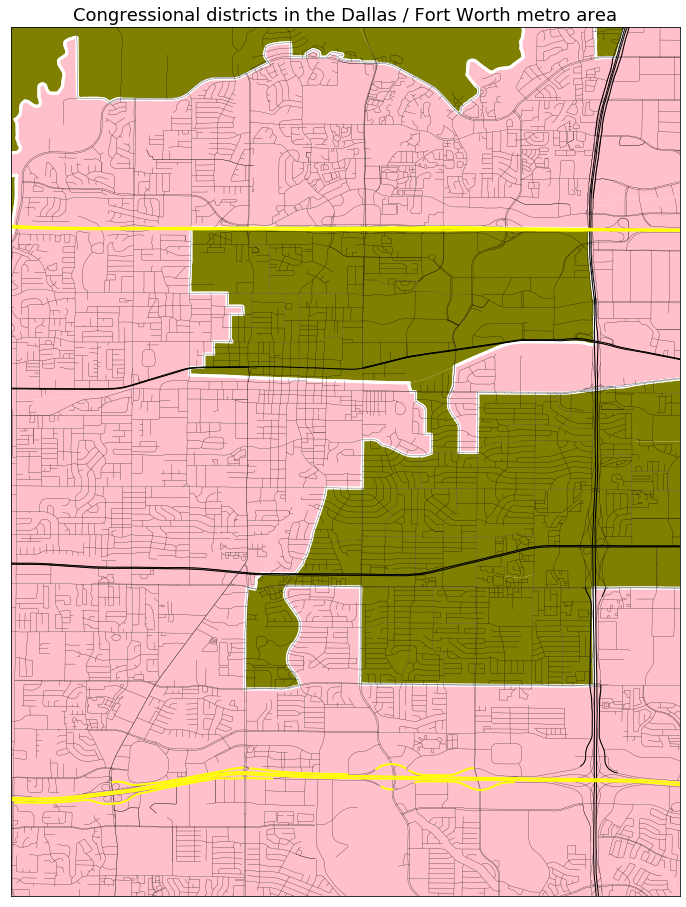

Done in 3 minutes 9 seconds!


In [15]:
s = time.time()
color_reset_point = 17
#assembler_gdf = assembler_gdf_bk
show_places = True
map_buffer_ratio = 0.2

#assembler_gdf.loc[assembler_gdf['block_based_district'] < 0, 'block_based_district'] = -1

# xlimits = [dallas_west_limit, dallas_east_limit]
# ylimits = [dallas_south_limit, dallas_north_limit]

# xlimits = [-97.5,-96.4]
# ylimits = [32.4, 33.2]

xlimits = [-97.15,-97.05]
ylimits = [32.66,32.79]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio


plotbox = makebox(xlimits,ylimits)


this_state = 'TX'
nDistricts = 36


#thedistricts = [6,30,33]

print('Finding districts present in data...')
thedistricts = []
for k in range(1,nDistricts+1):
    for x in assembler_gdf[(assembler_gdf.geometry.apply(lambda x: x.within(plotbox))) & (assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['in_dallas'] == True)]['congressional_districts_bitmask'].drop_duplicates().tolist():
        if (x[k] == '1'):
            if (k not in thedistricts):
                thedistricts.append(k)
print(thedistricts)

legend_location = 'upper left'

map_buffer_ratio = .05

fig, ax = plt.subplots(1,1,figsize=(16,16))

print('plotting block-group-based districts...')

for i in thedistricts:
    print('Plotting interior of District {0:,.0f}...'.format(i))
    if (i <= 18):
        assembler_gdf[
            (assembler_gdf['STUSAB'] == this_state)
            & (assembler_gdf['block_based_district'] == i)
        ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='none', lw=0.25)
    else:
        assembler_gdf[
            (assembler_gdf['STUSAB'] == this_state)
            & (assembler_gdf['block_based_district'] == i)
        ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='none', lw=0.25)

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
    
for i in thedistricts:
    print('Plotting boundary of District {0:.0f}...'.format(i))
    this_district_boundary_geo = unary_union(assembler_gdf[
        (assembler_gdf['STUSAB'] == 'TX') 
        & (assembler_gdf['block_based_district'] == i)
    ].geometry.tolist())
    
    this_district_boundary_gdf = geopandas.GeoDataFrame(data=[[this_district_boundary_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')
    this_district_boundary_gdf.plot(ax=ax, color='none', edgecolor='white', lw=3)

    
# print('plotting water...')    
# water_dallas_gdf[
#     (water_dallas_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_dallas_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_dallas_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_dallas_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax, color='blue')


print('plotting roads...')  
roads_dallas_gdf[~roads_dallas_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=0.25) 
roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=0.5) 
roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=1) 
roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=1.5) 
roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=2) 
    
plt.xticks([])
plt.yticks([])
plt.title('Congressional districts in the Dallas / Fort Worth metro area', fontsize=18)

fig.savefig('dallas-closeup.jpg', format='jpg')
plt.show()

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


# Show Maryland's 3rd District

	Reading file 1 of 24...
	Reading file 11 of 24...
	Reading file 21 of 24...
	Reading file 24 of 24...


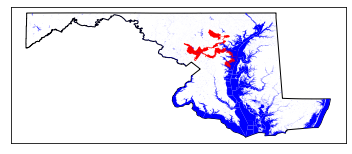

Done!


In [18]:
fig,ax = plt.subplots(1,1)
cd_gdf[(cd_gdf['STUSAB'] == 'MD') & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='red')


water_md_gdf = geopandas.GeoDataFrame()
md_state_number = 24
water_md_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(md_state_number) in x))]

for i in range(0, len(water_md_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_md_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_md_file_list)))
    water_md_gdf_i = geopandas.read_file(water_md_file_list[i])    
    water_md_gdf = pandas.concat((water_md_gdf, water_md_gdf_i), axis=0, sort=False)

md_boundary_geo = unary_union(assembler_gdf[assembler_gdf['STUSAB'] == 'MD'].geometry.tolist())
md_boundary_gdf = geopandas.GeoDataFrame(data = [[md_boundary_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')
md_boundary_gdf.plot(ax=ax, color='none', edgecolor='black')
water_md_gdf.plot(ax=ax, color='blue')
plt.xticks([])
plt.yticks([])
plt.show()
fig.savefig('md3.jpg', format='jpg')
print('Done!')


# Show Australia's electoral districts

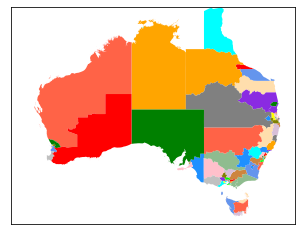

In [132]:
agdf = geopandas.read_file(script_dir+'australia/COM_ELB_region.shp')

fig, ax = plt.subplots(1,1)
for ix, thisrow in agf.iterrows():
    agdf[agdf.index == ix].plot(ax=ax,color=district_color_cycle[np.mod(ix,18)-1])
#plt.show()
plt.xlim([109,156])
plt.ylim([-45,-9])
plt.xticks([])
plt.yticks([])
# fig.savefig('australia.jpg', format='jpg')
# print("Done!")
plt.show()

# Make the block-based district shapefiles

In [69]:
# s = time.time()
# block_based_districts_gdf = geopandas.GeoDataFrame(data=None, columns=['total_population', 'geometry'], crs=assembler_gdf, geometry='geometry')
# #for this_state in ['MD']:
# for this_state in assembler_gdf['STUSAB'].drop_duplicates().sort_values().tolist()[:41]+assembler_gdf['STUSAB'].drop_duplicates().sort_values().tolist()[42:]:
#     print('Processing {0:}...'.format(this_state))
#     for i in range(1, int(assembler_gdf[assembler_gdf['STUSAB'] == this_state]['block_based_district'].max())+1):
#         newix = '{0:}-{1:.0f}'.format(this_state,i)
#         print('\tProcessing {0:}...'.format(newix))
#         newgeo = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)].geometry.tolist())
#         newpop = assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == i)]['total_population'].sum()
#         block_based_districts_gdf.loc[newix, ['total_population', 'geometry']] = [newpop, newgeo]
# e = time.time()
# g = g + (e-s)
# print('Found {0:,.0f} block-based districts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(block_based_districts_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))



# Calculate PP Score

Calculating PP score of official districts...


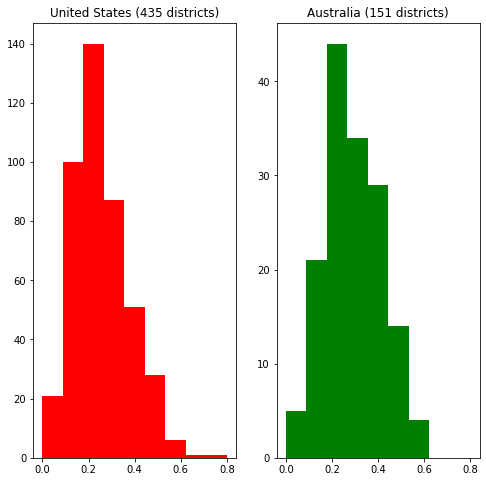

USA: mean PP = 0.256; stdevp = 0.119 (n = 435)
Australia: mean PP = 0.294; stdevp = 0.121 (n = 151)


In [157]:
if ('pp' not in cd_gdf.columns):
    cd_gdf = cd_gdf.assign(pp = np.nan)
if ('pp' not in agf.columns):
    agdf = agdf.assign(pp = np.nan)
# if ('pp' not in block_based_districts_gdf.columns):
#     block_based_districts_gdf = block_based_districts_gdf.assign(pp = np.nan)
print('Calculating PP score of official districts...')
cd_gdf.loc[:, 'pp'] = cd_gdf.geometry.apply(lambda x: ((4*np.pi*x.area) / (x.boundary.length ** 2)))
agdf.loc[:, 'pp'] = agdf.geometry.apply(lambda x: ((4*np.pi*x.area) / (x.boundary.length ** 2)))

# print('Calculating PP score of block group based districts...')
# block_based_districts_gdf.loc[:, 'pp'] = block_based_districts_gdf.geometry.apply(lambda x: ((4*np.pi*x.area) / (x.boundary.length ** 2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
ax1.hist(cd_gdf['pp'], usabins, color=district_color_cycle[0])
ax2.hist(agdf['pp'], ausbins, color=district_color_cycle[1])

ax1.set_title('United States ({0:,.0f} districts)'.format(len(cd_gdf)))
ax2.set_title('Australia ({0:,.0f} districts)'.format(len(agdf)))

plt.show()
#corrector_usa = (len(cd_gdf) - 1) / len(cd_gdf)
print('USA: mean PP = {0:.3f}; stdevp = {1:.3f} (n = {2:.0f})'.format(cd_gdf['pp'].mean(), cd_gdf['pp'].std(), len(cd_gdf)))
print('Australia: mean PP = {0:.3f}; stdevp = {1:.3f} (n = {2:.0f})'.format(agdf['pp'].mean(), agdf['pp'].std(), len(agdf)))





# Who represents the districts with the highest PP?

In [268]:
cd_gdf.drop('rank', axis=1)
if ('rank' not in cd_gdf.columns):
    cd_gdf = cd_gdf.assign(rank = np.nan, dtype='integer')
if ('representative' not in cd_gdf.columns):
    cd_gdf = cd_gdf.assign(representative = np.nan)
if ('representative_party' not in cd_gdf.columns):
    cd_gdf = cd_gdf.assign(representative_party = np.nan)

cd_gdf.loc['50000US3913', 
           ['rank', 'representative', 'representative_party']
          ] = [16, 'Tim Ryan', 'D']
cd_gdf.loc['50000US4818', 
           ['rank', 'representative', 'representative_party']
          ] = [15, 'Sheila Jackson Lee', 'D']
cd_gdf.loc['50000US2408', 
           ['rank', 'representative', 'representative_party']
          ] = [14, 'Jamie Raskin', 'D']
cd_gdf.loc['50000US4506', 
           ['rank', 'representative', 'representative_party']
          ] = [13, 'Jim Clyburn', 'D']
cd_gdf.loc['50000US1707', 
           ['rank', 'representative', 'representative_party']
          ] = [12, 'Danny K. Davis', 'D']
cd_gdf.loc['50000US4802', 
           ['rank', 'representative', 'representative_party']
          ] = [11, 'Dan Crenshaw', 'R']
cd_gdf.loc['50000US2206', 
           ['rank', 'representative', 'representative_party']
          ] = [10, 'Garret Graves', 'R']
cd_gdf.loc['50000US2507', 
           ['rank', 'representative', 'representative_party']
          ] = [9, 'Ayanna Presley', 'D']
cd_gdf.loc['50000US2406', 
           ['rank', 'representative', 'representative_party']
          ] = [8, 'David Trone', 'D']
cd_gdf.loc['50000US2402', 
           ['rank', 'representative', 'representative_party']
          ] = [7, 'Dutch Ruppersberger', 'D']
cd_gdf.loc['50000US2202', 
           ['rank', 'representative', 'representative_party']
          ] = [6, 'Vacant', 'X']
cd_gdf.loc['50000US3903', 
           ['rank', 'representative', 'representative_party']
          ] = [5, 'Joyce Beatty', 'D']
cd_gdf.loc['50000US4835', 
           ['rank', 'representative', 'representative_party']
          ] = [4, 'Lloyd Doggett', 'D']
cd_gdf.loc['50000US1704', 
           ['rank', 'representative', 'representative_party']
          ] = [3, 'Chuy Garcia', 'D']
cd_gdf.loc['50000US4833', 
           ['rank', 'representative', 'representative_party']
          ] = [2, 'Marc Veasey', 'D']
cd_gdf.loc['50000US2403', 
           ['rank', 'representative', 'representative_party']
          ] = [1, 'John Sarbanes', 'D']

#cd_gdf.loc[:, 'rank'] = pandas.to_numeric(cd_gdf['rank'], downcast='integer')
print('ok')

ok


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


plotting 16-highest PP district...
plotting 15-highest PP district...
plotting 14-highest PP district...
plotting 13-highest PP district...
plotting 12-highest PP district...
plotting 11-highest PP district...
plotting 10-highest PP district...
plotting 9-highest PP district...
plotting 8-highest PP district...
plotting 7-highest PP district...
plotting 6-highest PP district...
plotting 5-highest PP district...
plotting 4-highest PP district...
plotting 3-highest PP district...
plotting 2-highest PP district...
plotting 1-highest PP district...


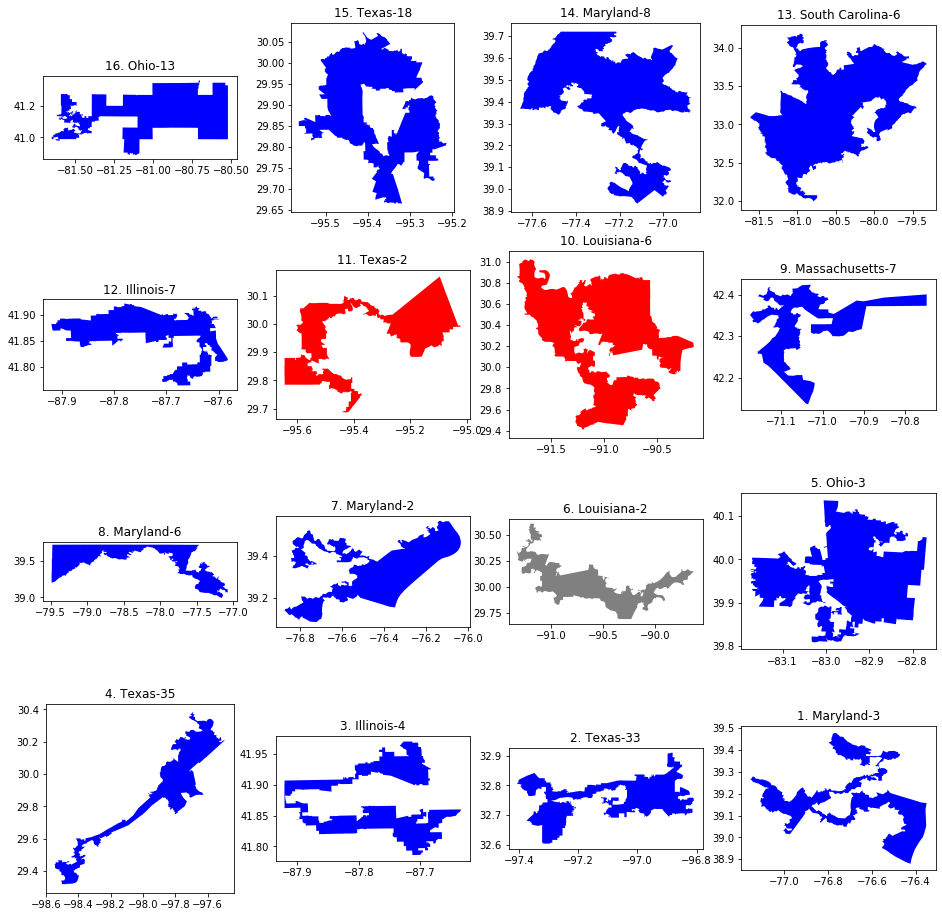

In [273]:
# ## Most gerrymandered districts in US

small_states = ['AK', 'DE', 'MT', 'ND', 'SD', 'VT', 'WY', 'HI']

# bins = np.linspace(0,0.08,32)

# fig, ax = plt.subplots(1,1)

# ax.hist(cd_gdf[~cd_gdf['STUSAB'].isin(one_district_states)]['pp'], bins)
# plt.show()





#cd_gdf['STUSAB'].value_counts()


#cd_gdf[~cd_gdf['STUSAB'].isin(one_district_states)]['pp'].sort_values()
#cd_gdf.loc['50000US1213']

#cd_gdf[cd_gdf.index == '50000US1213'].plot()
#cd_gdf[~cd_gdf['STUSAB'].isin(one_district_states)]['pp'].mean()


allax = []
for i in range(1,17):
    allax.append('ax{0:.0f}'.format(i))

fig, [
    [ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, ax10, ax11, ax12], [ax13, ax14, ax15, ax16]
] = plt.subplots(4,4,figsize=(16,16))

winners_list = cd_gdf[~cd_gdf['STUSAB'].isin(small_states)][['STUSAB', 'CD116FP', 'pp']][cd_gdf['pp'] <= 0.083].sort_values(by='pp', ascending=False).index.tolist()

i = 0
theedgecolor = 'none'
for thisax in fig.axes:
    thisax.set_aspect('equal')
    print('plotting {0:,.0f}-highest PP district...'.format(16-i))
    if (cd_gdf['representative_party'].loc[winners_list[i]] == 'R'):
        plotcolor= 'red'
    elif (cd_gdf['representative_party'].loc[winners_list[i]] == 'D'):
        plotcolor = 'blue'
    else:
        plotcolor='gray'
        theedgecolor = 'black'
    cd_gdf[cd_gdf.index == winners_list[i]].plot(ax=thisax, color=plotcolor)
    thisax.set_title('{0:}. {1:}-{2:.0f}'.format(16-i,cd_gdf['STATE_NAME'].loc[winners_list[i]], cd_gdf['CD116FP'].loc[winners_list[i]]))
    i += 1

plt.show()


50000US3903: Ohio-3
50000US4835: Texas-35
50000US1704: Illinois-4
50000US4833: Texas-33
50000US2403: Maryland-3


In [231]:
#cd_gdf